In [1]:
%load_ext autoreload
%autoreload 2
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

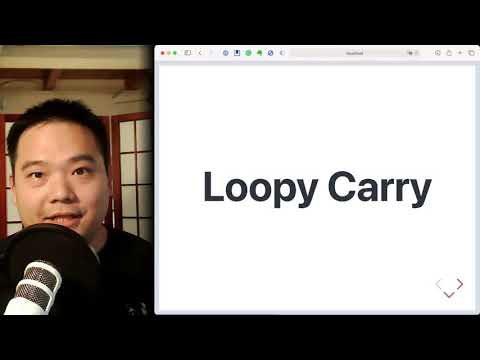

In [2]:
from IPython.display import YouTubeVideo, display

YouTubeVideo("6pnl7Eu2wN0")

# Eliminating for-loops that have carry-over using `lax.scan`

We are now going to see how we can eliminate for-loops that have carry-over using `lax.scan`.

From the JAX docs, `lax.scan` replaces a for-loop with carry-over,
with some of my own annotations added in for clarity:

> Scan a function over leading array axes while carrying along state.

The semantics are described as follows:

```python
def scan(f, init, xs, length=None):
    if xs is None:
         xs = [None] * length
    carry = init
    ys = []
    for x in xs:
        carry, y = f(carry, x)  # carry is the carryover
        ys.append(y)            # the `y`s get accumulated into a stacked array
    return carry, np.stack(ys)
```

A key requirement of the function `f`,
which is the function that gets scanned over the array `xs`,
is that it must have only two positional arguments in there,
one for `carry` and one for `x`.
You'll see how we can thus apply `functools.partial`
to construct functions that have this signature
from other functions that have more arguments present.

Let's see some concrete examples of this in action.

## Example: Cumulative Summation

One example where we might use a for-loop
is in the cumulative sum or product of an array.
Here, we need the current loop information to update the information from the previous loop.
Let's see it in action for the cumulative sum:

In [3]:
import jax.numpy as np

a = np.array([1, 2, 3, 5, 7, 11, 13, 17])

result = []
res = 0
for el in a:
    res += el
    result.append(res)
np.array(result)

DeviceArray([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

This is identical to the cumulative sum:

In [4]:
np.cumsum(a)

DeviceArray([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

Now, let's write it using `lax.scan`, so we can see the pattern in action:

In [5]:
from jax import lax


def cumsum(res, el):
    """
    - `res`: The result from the previous loop.
    - `el`: The current array element.
    """
    res = res + el
    return res, res  # ("carryover", "accumulated")


result_init = 0
final, result = lax.scan(cumsum, result_init, a)
result

DeviceArray([ 1,  3,  6, 11, 18, 29, 42, 59], dtype=int32)

As you can see, scanned function has to return two things:

- One object that gets carried over to the next loop (`carryover`), and
- Another object that gets "accumulated" into an array (`accumulated`).

The starting initial value, `result_init`, is passed into the `scanfunc` as `res` on the first call of the `scanfunc`. On subsequent calls, the first `res` is passed back into the `scanfunc` as the new `res`.

## Exercise 1: Simulating compound interest

We can use `lax.scan` to generate data that simulates
the generation of wealth by compound interest.
Here's an implementation using a plain vanilla for-loop:

In [6]:
wealth_record = []
starting_wealth = 100.0
interest_factor = 1.01
num_timesteps = 100
prev_wealth = starting_wealth

for t in range(num_timesteps):
    new_wealth = prev_wealth * interest_factor
    wealth_record.append(prev_wealth)
    prev_wealth = new_wealth

wealth_record = np.array(wealth_record)

Now, your challenge is to implement it in a `lax.scan` form.
Implement the `wealth_at_time` function below.

In [10]:
from functools import partial


def wealth_at_time(prev_wealth, time, interest_factor):
    # The lax.scannable function to compute wealth at a given time.
    new_wealth = prev_wealth * interest_factor
    return new_wealth, prev_wealth

wealth_func = partial(wealth_at_time, interest_factor=interest_factor)
timesteps = np.arange(num_timesteps)
final, result = lax.scan(wealth_func, init=starting_wealth, xs=timesteps)

assert np.allclose(wealth_record, result)

The two are equivalent, so we know we have the `lax.scan` implementation right.

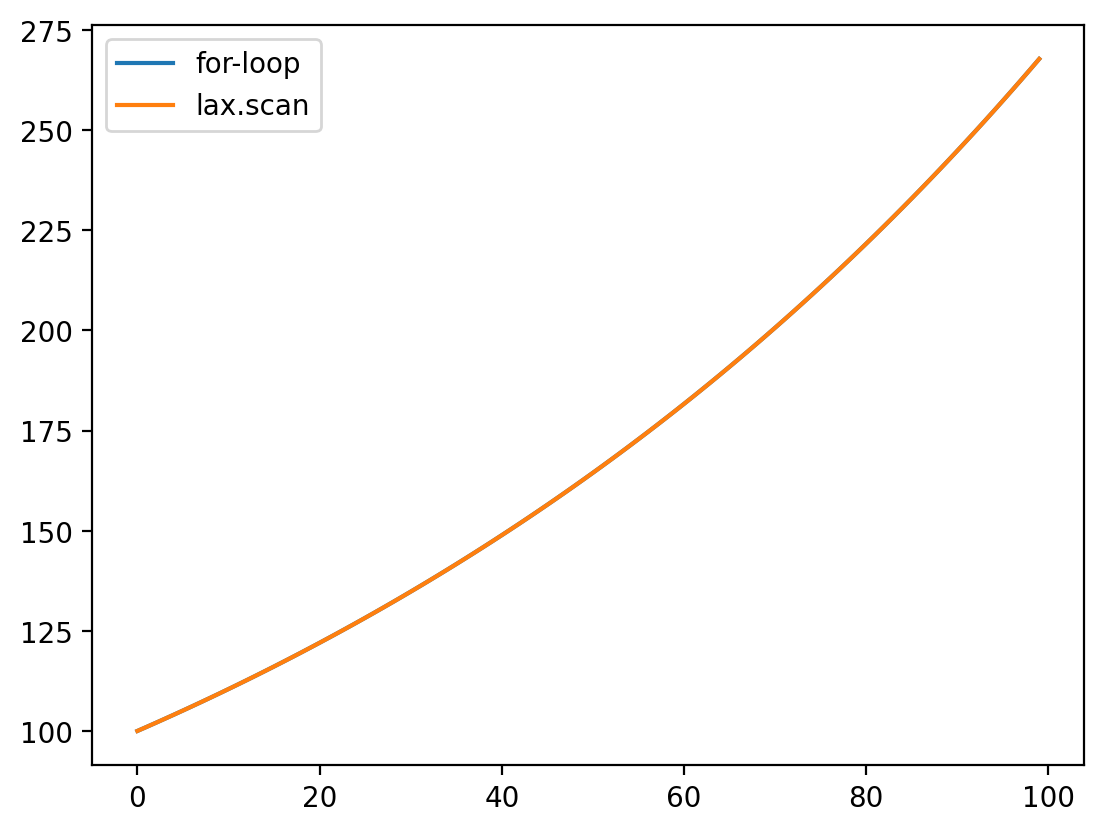

In [9]:
import matplotlib.pyplot as plt

plt.plot(wealth_record, label="for-loop")
plt.plot(result, label="lax.scan")
plt.legend();

## Example: Simulating compound interest from multiple starting points

Previously, was one simulation of wealth generation by compound interest
from one starting amount of money.
Now, let's simulate the wealth generation
for different starting wealth levels;
we will use 300 starting points however levels here.
This will be a demonstration of how to compose `lax.scan` with `vmap`
to do computation without loops.

To do so, you'll likely want to start with a function
that accepts a scalar starting wealth
and generates the simulated time series from there,
and then `vmap` that function across multiple starting points (which is an array itself).

In [11]:
from jax import vmap


def simulate_compound_interest(
    starting_wealth: np.ndarray, timesteps: np.ndarray
):
    # this is wealth_func from previous exercise
    final, result = lax.scan(wealth_func, init=starting_wealth, xs=timesteps)
    return final, result

# number of time steps to compute scan across
num_timesteps = np.arange(200)

# random starting point levels
starting_wealths = np.arange(300).astype(float)

simulation_func = partial(simulate_compound_interest, timesteps=np.arange(200))

final, growth = vmap(simulation_func)(starting_wealths)
growth.shape

(300, 200)

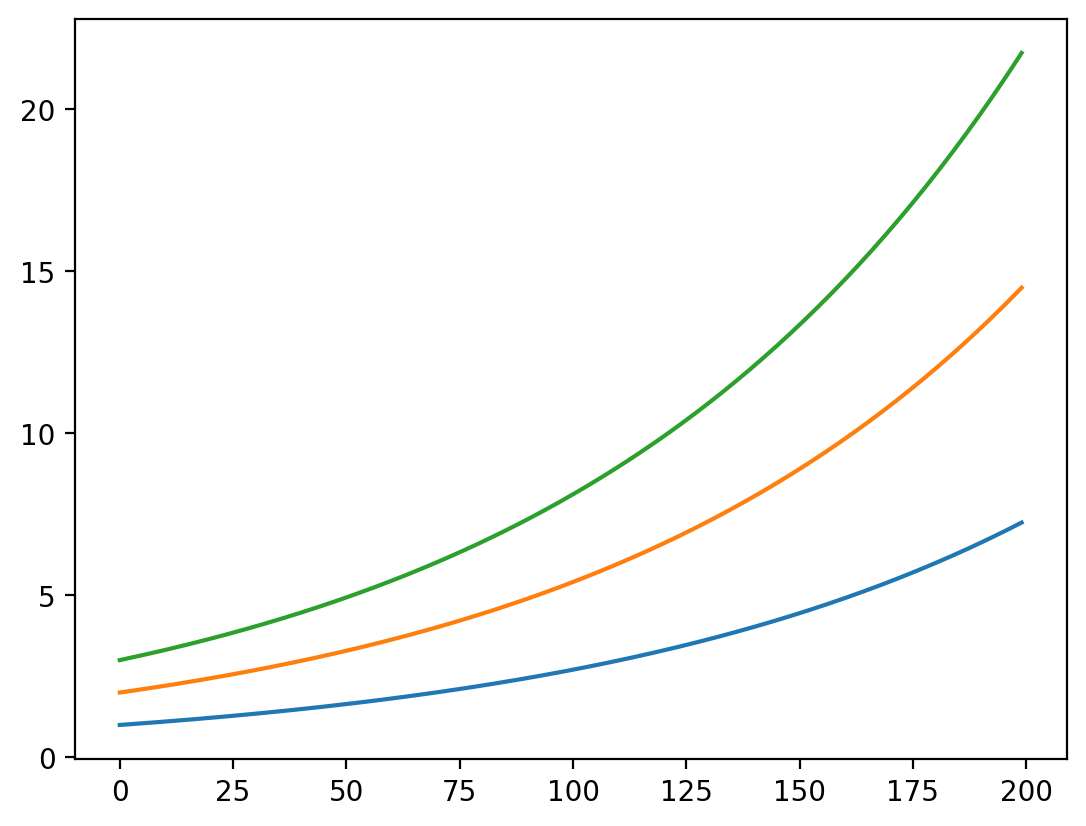

In [12]:
plt.plot(growth[1])
plt.plot(growth[2])
plt.plot(growth[3]);

## Exercise 2: Stick breaking process

The [stick breaking process][stickbreaking] is one that is important in Bayesian non-parametric modelling,
where we want to model something that may have potentially an infinite number of components
while being biased towards a smaller subset of components.

The stick-breaking process uses the following generative process:

1. Take a stick of length 1.
2. Draw a number between 0 and 1 from a Beta distribution (we will modify this step for this notebook).
3. Break that fraction of the stick, and leave it aside in a pile.
4. Repeat steps 2 and 3 with the fraction leftover after breaking the stick.

We repeat _ad infinitum_ (in theory) 
or until a pre-specified large number of stick breaks have happened (in practice).

In the exercise below, your task is to write the stick-breaking process
in terms of a `lax.scan` operation.
Because we have not yet covered drawing random numbers using JAX,
the breaking fraction will be a fixed variable rather than a random variable.
Here's the vanilla NumPy + Python equivalent for you to reference.

[stickbreaking]: https://en.wikipedia.org/wiki/Dirichlet_process#The_stick-breaking_process

In [28]:
# NumPy equivalent

num_breaks = 30
breaking_fraction = 0.1

sticks = []
stick_length = 1.0
for i in range(num_breaks):
    stick = stick_length * breaking_fraction
    sticks.append(stick)
    stick_length = stick_length - stick
sticks = np.array(sticks)
sticks

DeviceArray([0.1       , 0.09      , 0.081     , 0.0729    , 0.06561   ,
             0.059049  , 0.0531441 , 0.04782969, 0.04304672, 0.03874205,
             0.03486785, 0.03138106, 0.02824295, 0.02541866, 0.02287679,
             0.02058911, 0.0185302 , 0.01667718, 0.01500946, 0.01350852,
             0.01215767, 0.0109419 , 0.00984771, 0.00886294, 0.00797664,
             0.00717898, 0.00646108, 0.00581497, 0.00523348, 0.00471013],            dtype=float32)

In [29]:
def lax_scan_ex_2(num_breaks: int, frac: float):
    def break_stick(stick_length, n):
        dropped_stick = stick_length * frac
        remaining_stick = stick_length - dropped_stick
        return remaining_stick, dropped_stick 
    final, sticks = lax.scan(break_stick, init=1.0, xs=np.arange(num_breaks))
    return sticks


sticksres = lax_scan_ex_2(num_breaks, breaking_fraction)
assert np.allclose(sticksres, sticks)